In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
baseline_vars_df = pd.read_csv('baseline_data.csv')

In [16]:
baseline_df = pd.read_csv('baseline_data.csv')

In [17]:
baseline_df

,year,qtr,state_fips,low,high,FIPS,State,YearQuarter,profitability,asset_quality
0,1999,1,1,0.40,1.11,1,alabama,1999Q1,0.001911,0.003194
1,1999,2,1,1.11,1.24,1,alabama,1999Q2,0.001911,0.003194
2,1999,3,1,0.40,1.11,1,alabama,1999Q3,0.001911,0.003194
3,1999,4,1,0.40,1.11,1,alabama,1999Q4,0.001911,0.003194
4,2000,1,1,1.11,1.24,1,alabama,2000Q1,0.005936,0.003637
...,...,...,...,...,...,...,...,...,...,...
1895,2007,2,56,1.32,1.40,56,wyoming,2007Q2,0.008248,0.000955
1896,2007,3,56,1.32,1.40,56,wyoming,2007Q3,0.008248,0.000955
1897,2007,4,56,1.32,1.40,56,wyoming,2007Q4,0.008248,0.000955
1898,2008,1,56,1.32,1.40,56,wyoming,2008Q1,0.006264,0.003617


In [24]:
print(baseline_vars_df["high"].values)

[1.11 1.24 1.11 ... 1.4  1.4  1.4 ]


In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [10]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Assume baseline_vars_df is your DataFrame with columns: "State", "asset_quality", "profitability", "high"
selected_vars = ["asset_quality", "profitability", "low"]
X = baseline_vars_df[selected_vars].values
states = baseline_vars_df["State"].values

# Standardize the features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Use PCA with whitening to obtain a whitened representation
pca = PCA(whiten=True, random_state=42)
X_whitened = pca.fit_transform(X_scaled)

# Run K-means clustering on the whitened data (this now uses the PCA-based whitening which is robust)
k = 4  # choose appropriate number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_whitened)

# For each state, compute Euclidean distance in the whitened space to its assigned cluster centroid
distances = []
for i in range(len(states)):
    centroid = kmeans.cluster_centers_[clusters[i]]
    d = np.linalg.norm(X_whitened[i] - centroid)
    distances.append(d)

# Use negative distances as the similarity (G) score (higher means more similar to the centroid)
kmeans_mahalanobis_scores = pd.DataFrame({
    "State": states,
    "kmeans_mahalanobis_score": -np.array(distances)
})

print("K-Means (Mahalanobis via PCA Whitening) G-Scores:")
print(kmeans_mahalanobis_scores.sort_values("kmeans_mahalanobis_score", ascending=False).head(10))


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


K-Means (Mahalanobis via PCA Whitening) G-Scores:
          State  kmeans_mahalanobis_score
125    arkansas                 -0.046610
124    arkansas                 -0.046610
123    arkansas                 -0.046610
122    arkansas                 -0.046610
1832  wisconsin                 -0.057055
1834  wisconsin                 -0.057055
1833  wisconsin                 -0.057055
1835  wisconsin                 -0.057055
687       maine                 -0.062837
685       maine                 -0.062837


In [22]:
print(baseline_vars_df.isna().sum())


year               0
qtr                0
state_fips         0
low                0
high             153
FIPS               0
State              0
YearQuarter        0
profitability      0
asset_quality      0
dtype: int64


In [21]:
# Check if there are any NaN values in X_scaled
has_null = np.isnan(X_scaled).any()
print("Yes" if has_null else "No")

Yes


In [11]:
# Select the baseline variables for G-selection
selected_vars = ["asset_quality", "profitability", "low"]
X = baseline_vars_df[selected_vars].values
states = baseline_vars_df["State"].values

# Standardize the features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Compute the covariance matrix and its inverse square root (whitening transformation)
cov_matrix = np.cov(X_scaled, rowvar=False)
eigvals, eigvecs = np.linalg.eigh(cov_matrix)
inv_sqrt_eigvals = np.diag(1.0 / np.sqrt(eigvals))
D = eigvecs.dot(inv_sqrt_eigvals).dot(eigvecs.T)

# Whiten the data; now Euclidean distance equals Mahalanobis distance
X_whitened = X_scaled.dot(D)

# Run K-means clustering on the whitened data (choose k based on your data; here k=4)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_whitened)

# For each state, compute the Euclidean distance from its whitened feature vector to its cluster centroid
distances = []
for i in range(len(states)):
    centroid = kmeans.cluster_centers_[clusters[i]]
    d = np.linalg.norm(X_whitened[i] - centroid)
    distances.append(d)

# Use the negative distance as the similarity (G) score (higher means more similar)
kmeans_mahalanobis_scores = pd.DataFrame({
    "State": states,
    "G_score": -np.array(distances)
})

print("K-Means (Mahalanobis) G-Scores:")
print(kmeans_mahalanobis_scores.sort_values("G_score", ascending=False).head(10))

d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


K-Means (Mahalanobis) G-Scores:
          State   G_score
125    arkansas -0.046610
124    arkansas -0.046610
123    arkansas -0.046610
122    arkansas -0.046610
1832  wisconsin -0.057055
1834  wisconsin -0.057055
1833  wisconsin -0.057055
1835  wisconsin -0.057055
687       maine -0.062837
685       maine -0.062837


Each state’s G-score represents how similar that state’s economic baseline is to the "typical" state in its group, as determined by clustering in a transformed (whitened) feature space. Because we used the negative of the Euclidean distance, a less-negative (or higher) score means the state is closer to its cluster centroid—that is, it more closely resembles the average pattern within its cluster. Conversely, more negative scores indicate the state deviates further from the group’s center, making it less "typical" relative to its peers.

For example, in your output:
- **Arkansas** shows a score of –0.0466. This relatively higher (less-negative) score suggests that Arkansas’s baseline characteristics (asset quality, profitability, and high) are close to the centroid of its cluster—it is very representative of that group.
- **Wisconsin** has a score around –0.0571, slightly lower (more negative) than Arkansas, implying that it is a bit further from its cluster centroid.
- **Maine** shows a score of –0.0628, which is more negative and indicates that Maine is less typical compared to the centroid of its cluster.

In summary, the grouped scores help you quickly assess which states have baseline features that are more central (and thus more similar to other states within their cluster) and which ones are outliers. This similarity measure (or G-score) can then inform your matching process for synthetic control, by either weighting states or selecting a donor pool composed of states with high (less-negative) G-scores.

Grouped K-Means Mahalanobis G-Scores by State:
            State   G_score
6     connecticut -0.391552
20  massachusetts -0.403329
48      wisconsin -0.416817
16       kentucky -0.427755
30     new mexico -0.438289
24       missouri -0.452883
1          alaska -0.461843
33   north dakota -0.486807
44        vermont -0.486967
14           iowa -0.498744


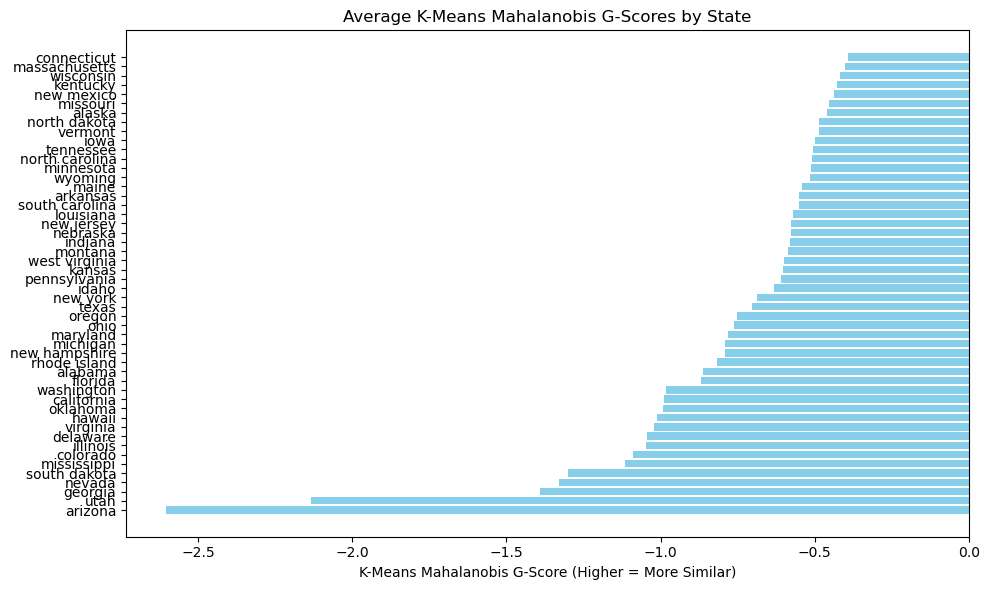

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the scores by State (averaging if there are duplicates)
grouped_scores = kmeans_mahalanobis_scores.groupby("State")["G_score"].mean().reset_index()

# Sort by score descending, so that the highest (i.e., least negative) scores are at the top.
grouped_scores.sort_values("G_score", ascending=False, inplace=True)

print("Grouped K-Means Mahalanobis G-Scores by State:")
print(grouped_scores.head(10))

# Create a horizontal bar plot to visualize the scores
plt.figure(figsize=(10, 6))
plt.barh(grouped_scores["State"], grouped_scores["G_score"], color='skyblue')
plt.xlabel("K-Means Mahalanobis G-Score (Higher = More Similar)")
plt.title("Average K-Means Mahalanobis G-Scores by State")
plt.gca().invert_yaxis()  # So that the state with the highest score appears at the top
plt.tight_layout()
plt.show()


Negative Distance as a Similarity Score

You see negative values because you used –(Euclidean distance). A value closer to zero (e.g., –0.2) indicates a smaller original distance to the cluster centroid, meaning that state is more representative (or “typical”) of its cluster.

Large negative values (like –2.5) mean that state is relatively far from the centroid, making it less typical within its group.

Plot Interpretation

States at the top of the chart (with more negative bars) have lower G-scores, meaning they deviate more from their cluster’s average. They’re effectively “outliers” or “less similar” to the cluster.

States at the bottom (bars near zero) are the most similar to their cluster centroid and thus are “typical” examples within that cluster’s baseline features.

Why This Matters

If you’re using these G-scores to pick a donor pool or do baseline grouping, states with higher (less-negative) G-scores are more “central” and can be considered good representatives of that cluster’s patterns.

Conversely, states with very negative G-scores might be outliers to treat separately or investigate further for unique economic structures.

Practical Takeaways

Connecticut, Massachusetts, Wisconsin, and Kentucky (among others at the top) are relatively far from their cluster centroids, so they might be outliers in terms of your baseline variables (asset_quality, profitability, high).

States lower on the chart (closer to zero) are more typical or standard within their clusters. If you’re selecting controls for a synthetic control analysis, these states might end up being more likely to match well with treated states in the same cluster.

In short, the bar chart visually shows each state’s “distance from average” within its cluster. Higher bars (less negative) = more representative states; lower bars (very negative) = more atypical states in the context of the baseline features you used.

In [14]:
kmeans_mahalanobis_scores.to_csv('kmeans_mahalanobis_robust_scores.csv', index=False)

In [18]:
gdp_df = pd.read_csv('gdp_growth_data.csv')

gdp_df

,GeoFips,LineCode,Description,Time,GDP,State,YearQuarter,gdp_growth
0,1000,1,All industry total,2005:Q1,195673.0,alabama,2005 Q1,NaN
1,1000,1,All industry total,2005:Q2,197495.8,alabama,2005 Q2,0.009316
2,1000,1,All industry total,2005:Q3,196798.5,alabama,2005 Q3,-0.003531
3,1000,1,All industry total,2005:Q4,199018.6,alabama,2005 Q4,0.011281
4,1000,1,All industry total,2006:Q1,199142.9,alabama,2006 Q1,0.000625
...,...,...,...,...,...,...,...,...
2365,55000,1,All industry total,2023:Q3,346067.0,wisconsin,2023 Q3,0.013137
2366,55000,1,All industry total,2023:Q4,350266.1,wisconsin,2023 Q4,0.012134
2367,55000,1,All industry total,2024:Q1,349300.9,wisconsin,2024 Q1,-0.002756
2368,55000,1,All industry total,2024:Q2,352941.1,wisconsin,2024 Q2,0.010421


In [19]:
# ------------------------------------------------------------------
# 0)  Standardise YearQuarter in baseline_df  →  PeriodIndex
# ------------------------------------------------------------------
baseline_df["YearQuarter"] = (
    baseline_df["YearQuarter"]
      .astype(str)
      .str.replace(" Q", "Q", regex=False)      # "2005 Q2" → "2005Q2"
)
baseline_df["YearQuarter"] = pd.PeriodIndex(baseline_df["YearQuarter"], freq="Q")



In [21]:
base_start = pd.Period("2005Q1", freq="Q")
base_end   = pd.Period("2008Q2", freq="Q")

baseline_trim = baseline_df.loc[
    (baseline_df["YearQuarter"] >= base_start) &
    (baseline_df["YearQuarter"] <= base_end)
].copy()

baseline_trim

,year,qtr,state_fips,low,high,FIPS,State,YearQuarter,profitability,asset_quality
24,2005,1,1,1.50,1.6,1,alabama,2005Q1,0.004663,0.004323
25,2005,2,1,1.50,1.6,1,alabama,2005Q2,0.004663,0.004323
26,2005,3,1,1.40,1.5,1,alabama,2005Q3,0.004663,0.004323
27,2005,4,1,1.40,1.5,1,alabama,2005Q4,0.004663,0.004323
28,2006,1,1,1.40,1.5,1,alabama,2006Q1,0.004514,0.003980
...,...,...,...,...,...,...,...,...,...,...
1895,2007,2,56,1.32,1.4,56,wyoming,2007Q2,0.008248,0.000955
1896,2007,3,56,1.32,1.4,56,wyoming,2007Q3,0.008248,0.000955
1897,2007,4,56,1.32,1.4,56,wyoming,2007Q4,0.008248,0.000955
1898,2008,1,56,1.32,1.4,56,wyoming,2008Q1,0.006264,0.003617


In [22]:
# --------------------------------------------------------------
# Keep every quarter (1999Q1–2008Q2) without averaging anything
# --------------------------------------------------------------
baseline_long = baseline_trim.loc[
    :, ["State", "YearQuarter", "asset_quality", "profitability", "low"]
].copy()

# If you want a separate column that labels the first quarter in the window
# (purely for reference), add it but KEEP all rows:
first_q = (
    baseline_long
        .sort_values("YearQuarter")
        .groupby("State")["YearQuarter"]
        .first()
        .reset_index()
        
)

baseline_long = baseline_long.merge(first_q, on="State", how="left")

print(baseline_long.head())


     State YearQuarter_x  asset_quality  profitability  low YearQuarter_y
0  alabama        2005Q1       0.004323       0.004663  1.5        2005Q1
1  alabama        2005Q2       0.004323       0.004663  1.5        2005Q1
2  alabama        2005Q3       0.004323       0.004663  1.4        2005Q1
3  alabama        2005Q4       0.004323       0.004663  1.4        2005Q1
4  alabama        2006Q1       0.003980       0.004514  1.4        2005Q1


In [23]:
baseline_long.drop(columns=["YearQuarter_y"], inplace=True, axis=1)
baseline_long.rename(columns={"YearQuarter_x": "YearQuarter"}, inplace=True)

In [24]:
baseline_long

,State,YearQuarter,asset_quality,profitability,low
0,alabama,2005Q1,0.004323,0.004663,1.50
1,alabama,2005Q2,0.004323,0.004663,1.50
2,alabama,2005Q3,0.004323,0.004663,1.40
3,alabama,2005Q4,0.004323,0.004663,1.40
4,alabama,2006Q1,0.003980,0.004514,1.40
...,...,...,...,...,...
695,wyoming,2007Q2,0.000955,0.008248,1.32
696,wyoming,2007Q3,0.000955,0.008248,1.32
697,wyoming,2007Q4,0.000955,0.008248,1.32
698,wyoming,2008Q1,0.003617,0.006264,1.32


In [26]:
gdp_df = pd.read_csv("gdp_growth_data.csv")
gdp_df["State"] = gdp_df["State"].str.lower().str.strip()

# normalise YearQuarter string and convert to PeriodIndex
gdp_df["YearQuarter"] = (
    gdp_df["YearQuarter"].astype(str).str.replace(" Q", "Q", regex=False)
)
gdp_df["YearQuarter"] = pd.PeriodIndex(gdp_df["YearQuarter"], freq="Q")

pret_start = pd.Period("2005Q1", freq="Q")
pret_end   = pd.Period("2008Q2", freq="Q")

gdp_pre_long = (
    gdp_df.loc[
        (gdp_df["YearQuarter"] >= pret_start) &
        (gdp_df["YearQuarter"] <= pret_end)
    ][["State", "YearQuarter", "GDP"]]
      .rename(columns={"GDP": "GDP_pre"})
)

In [27]:
gdp_pre_long

,State,YearQuarter,GDP_pre
0,alabama,2005Q1,195673.0
1,alabama,2005Q2,197495.8
2,alabama,2005Q3,196798.5
3,alabama,2005Q4,199018.6
4,alabama,2006Q1,199142.9
...,...,...,...
2300,wisconsin,2007Q2,289401.7
2301,wisconsin,2007Q3,290829.8
2302,wisconsin,2007Q4,290612.7
2303,wisconsin,2008Q1,288584.9


In [28]:
merged_panel = baseline_long.merge(
    gdp_pre_long,
    on=["State", "YearQuarter"],
    how="inner"
)

print(merged_panel.head())
print("Rows:", len(merged_panel))

     State YearQuarter  asset_quality  profitability  low   GDP_pre
0  alabama      2005Q1       0.004323       0.004663  1.5  195673.0
1  alabama      2005Q2       0.004323       0.004663  1.5  197495.8
2  alabama      2005Q3       0.004323       0.004663  1.4  196798.5
3  alabama      2005Q4       0.004323       0.004663  1.4  199018.6
4  alabama      2006Q1       0.003980       0.004514  1.4  199142.9
Rows: 420


In [29]:
merged_panel

,State,YearQuarter,asset_quality,profitability,low,GDP_pre
0,alabama,2005Q1,0.004323,0.004663,1.5,195673.0
1,alabama,2005Q2,0.004323,0.004663,1.5,197495.8
2,alabama,2005Q3,0.004323,0.004663,1.4,196798.5
3,alabama,2005Q4,0.004323,0.004663,1.4,199018.6
4,alabama,2006Q1,0.003980,0.004514,1.4,199142.9
...,...,...,...,...,...,...
415,wisconsin,2007Q2,0.004020,0.004855,1.4,289401.7
416,wisconsin,2007Q3,0.004020,0.004855,1.4,290829.8
417,wisconsin,2007Q4,0.004020,0.004855,1.4,290612.7
418,wisconsin,2008Q1,0.019022,-0.007550,1.4,288584.9


In [32]:
merged_panel.to_csv("merged_panel.csv",index=False)

In [30]:
merged_panel = baseline_long.merge(
    gdp_pre_long,
    on=["State", "YearQuarter"],
    how="inner"
)

print(merged_panel.head())
print("Rows:", len(merged_panel))

     State YearQuarter  asset_quality  profitability  low   GDP_pre
0  alabama      2005Q2       0.004323       0.004663  1.5  0.009316
1  alabama      2005Q3       0.004323       0.004663  1.4 -0.003531
2  alabama      2005Q4       0.004323       0.004663  1.4  0.011281
3  alabama      2006Q1       0.003980       0.004514  1.4  0.000625
4  alabama      2006Q2       0.003980       0.004514  1.4  0.004461
Rows: 390


In [ ]:
merged_panel.to_csv('merged_panel.csv', index=False)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
merged_panel = pd.read_csv('merged_panel.csv')

## Adaptive Lasso

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
from sklearn.linear_model import LassoCV

In [35]:
merged_panel = pd.read_csv('merged_panel.csv')

In [36]:
vars_X = ["asset_quality", "profitability", "low"]
panel = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X = panel[vars_X].values
y = panel["GDP_pre"].values
states = panel["State"].values

### Standard Scaler

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#   2)  Initial OLS to get raw betas
# ------------------------------------------------------------------
beta_ols = np.linalg.lstsq(X_scaled, y, rcond=None)[0]

# Adaptive weight w_j = 1 / |beta_ols_j|^γ   (γ = 1)
gamma = 1.0
weights = 1.0 / (np.abs(beta_ols) ** gamma + 1e-8)

In [39]:
#   3)  Rescale columns of X by 1/weights  ➔  X_rescaled
# ------------------------------------------------------------------
X_rescaled = X_scaled / weights[np.newaxis, :]

# ------------------------------------------------------------------
#   4)  LassoCV on rescaled design
# ------------------------------------------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_rescaled, y)
beta_adaptive = lasso.coef_ / weights          # back‑transform coefficients

print("Adaptive‑Lasso coefficients:")
for v, b in zip(vars_X, beta_adaptive):
    print(f"  {v}: {b: .4f}")

# ------------------------------------------------------------------
#   5)  G‑score for each observation:   X_scaled · β_adaptive
# ------------------------------------------------------------------
panel["G_score_adaptive"] = X_scaled.dot(beta_adaptive)

Adaptive‑Lasso coefficients:
  asset_quality:  0.0000
  profitability: -0.0000
  low:  0.0000


In [40]:
adaptive_state_score = (
    panel.groupby("State")["G_score_adaptive"]
         .mean()
         .reset_index()
         .sort_values("G_score_adaptive", ascending=False)
)

In [41]:
# ---------------------------
# adaptive_state_score already exists
# columns:  State | G_score_adaptive
# ---------------------------
ranked_states = (
    adaptive_state_score
      .sort_values("G_score_adaptive", ascending=False)   # highest first
      .reset_index(drop=True)
      .rename(columns={"G_score_adaptive": "G_score"})
)

# Display the top 10 (or any slice you need)
print(ranked_states.head(10))


          State       G_score
0       georgia  7.318137e-11
1      michigan  5.870807e-11
2       alabama  5.838012e-11
3       florida  4.007221e-11
4      illinois  3.490433e-11
5    california  3.032440e-11
6      colorado  2.898760e-11
7       indiana  2.549793e-11
8  pennsylvania  2.455282e-11
9     wisconsin  1.833286e-11


In [42]:
ranked_states = (
    adaptive_state_score
      .sort_values("G_score_adaptive", ascending=False)
      .reset_index(drop=True)
      .rename(columns={"G_score_adaptive": "G_score"})
)


          State       G_score
0       georgia  7.318137e-11
1      michigan  5.870807e-11
2       alabama  5.838012e-11
3       florida  4.007221e-11
4      illinois  3.490433e-11
5    california  3.032440e-11
6      colorado  2.898760e-11
7       indiana  2.549793e-11
8  pennsylvania  2.455282e-11
9     wisconsin  1.833286e-11
          State       G_score
20      montana -1.221048e-11
21    tennessee -1.330197e-11
22        idaho -1.602515e-11
23       oregon -1.898130e-11
24       alaska -2.835995e-11
25  connecticut -3.003365e-11
26         ohio -3.073203e-11
27   washington -5.654297e-11
28     oklahoma -7.833410e-11
29         utah -1.067367e-10


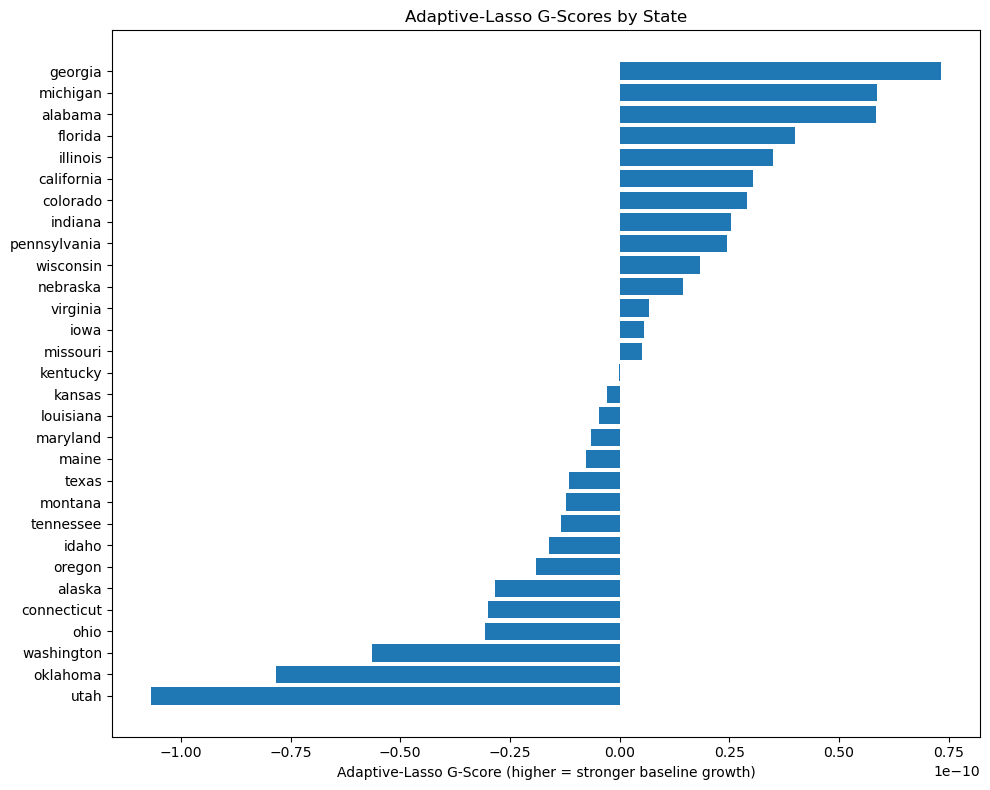

In [43]:
import matplotlib.pyplot as plt

# 0)  ensure `ranked_states` exists
print(ranked_states.head(10))          # top 10
print(ranked_states.tail(10))          # bottom 10

# 1)  horizontal bar chart of all states
plt.figure(figsize=(10, 8))
plt.barh(ranked_states["State"], ranked_states["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("Adaptive‑Lasso G‑Score (higher = stronger baseline growth)")
plt.title("Adaptive‑Lasso G‑Scores by State")
plt.tight_layout()
plt.show()



In [44]:
import numpy as np

# ------------------------------------------------------------
# y  and  X_scaled  were defined earlier
# beta_adaptive is the coefficient vector we estimated
# ------------------------------------------------------------
y_hat = X_scaled.dot(beta_adaptive)

# ----------  R‑squared --------------------------------------
ss_res = np.sum((y - y_hat) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2      = 1.0 - ss_res / ss_tot

# ----------  AIC / BIC  (Gaussian likelihood) ---------------
n  = len(y)                 # number of observations
k  = len(beta_adaptive)     # number of estimated parameters
sigma2 = ss_res / n         # ML estimate of error variance

# log‑likelihood for Gaussian errors with constant variance
logL = -0.5 * n * (np.log(2*np.pi*sigma2) + 1)

AIC = -2 * logL + 2 * k
BIC = -2 * logL + k * np.log(n)

print(f"Adaptive‑Lasso in‑sample metrics")
print(f"  R²   : {r2: .4f}")
print(f"  AIC  : {AIC: .1f}")
print(f"  BIC  : {BIC: .1f}")


Adaptive‑Lasso in‑sample metrics
  R²   : -0.8836
  AIC  :  12335.9
  BIC  :  12348.1


In [45]:
# n = observations, k = number of predictors
n = len(y)
k = X_scaled.shape[1]

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print(f"Adjusted R² : {adj_r2: .4f}")


Adjusted R² : -0.8972


In [ ]:
#   3)  Rescale columns of X by 1/weights  ➔  X_rescaled
# ------------------------------------------------------------------
X_rescaled = X_scaled / weights[np.newaxis, :]

# ------------------------------------------------------------------
#   4)  LassoCV on rescaled design
# ------------------------------------------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_rescaled, y)
beta_adaptive = lasso.coef_ / weights          # back‑transform coefficients

print("Adaptive‑Lasso coefficients:")
for v, b in zip(vars_X, beta_adaptive):
    print(f"  {v}: {b: .4f}")

# ------------------------------------------------------------------
#   5)  G‑score for each observation:   X_scaled · β_adaptive
# ------------------------------------------------------------------
panel["G_score_adaptive"] = X_scaled.dot(beta_adaptive)

### Robust Scaler

In [46]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

#   2)  Initial OLS to get raw betas
# ------------------------------------------------------------------
beta_ols = np.linalg.lstsq(X_scaled, y, rcond=None)[0]

# Adaptive weight w_j = 1 / |beta_ols_j|^γ   (γ = 1)
gamma = 1.0
weights = 1.0 / (np.abs(beta_ols) ** gamma + 1e-8)

In [47]:
adaptive_state_score = (
    panel.groupby("State")["G_score_adaptive"]
         .mean()
         .reset_index()
         .sort_values("G_score_adaptive", ascending=False)
)

In [48]:
# ---------------------------
# adaptive_state_score already exists
# columns:  State | G_score_adaptive
# ---------------------------
ranked_states = (
    adaptive_state_score
      .sort_values("G_score_adaptive", ascending=False)   # highest first
      .reset_index(drop=True)
      .rename(columns={"G_score_adaptive": "G_score"})
)

# Display the top 10 (or any slice you need)
print(ranked_states.head(10))


          State       G_score
0       georgia  7.318137e-11
1      michigan  5.870807e-11
2       alabama  5.838012e-11
3       florida  4.007221e-11
4      illinois  3.490433e-11
5    california  3.032440e-11
6      colorado  2.898760e-11
7       indiana  2.549793e-11
8  pennsylvania  2.455282e-11
9     wisconsin  1.833286e-11


In [49]:
ranked_states = (
    adaptive_state_score
      .sort_values("G_score_adaptive", ascending=False)
      .reset_index(drop=True)
      .rename(columns={"G_score_adaptive": "G_score"})
)

          State       G_score
0       georgia  7.318137e-11
1      michigan  5.870807e-11
2       alabama  5.838012e-11
3       florida  4.007221e-11
4      illinois  3.490433e-11
5    california  3.032440e-11
6      colorado  2.898760e-11
7       indiana  2.549793e-11
8  pennsylvania  2.455282e-11
9     wisconsin  1.833286e-11
          State       G_score
20      montana -1.221048e-11
21    tennessee -1.330197e-11
22        idaho -1.602515e-11
23       oregon -1.898130e-11
24       alaska -2.835995e-11
25  connecticut -3.003365e-11
26         ohio -3.073203e-11
27   washington -5.654297e-11
28     oklahoma -7.833410e-11
29         utah -1.067367e-10


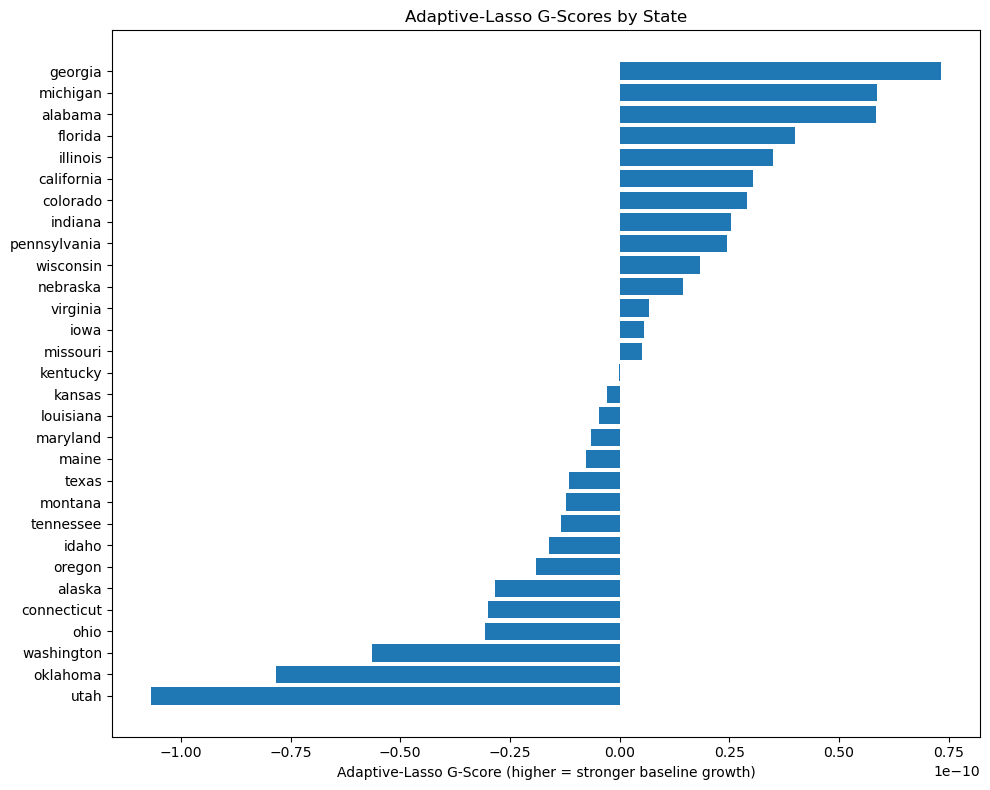

In [50]:
import matplotlib.pyplot as plt

# 0)  ensure `ranked_states` exists
print(ranked_states.head(10))          # top 10
print(ranked_states.tail(10))          # bottom 10

# 1)  horizontal bar chart of all states
plt.figure(figsize=(10, 8))
plt.barh(ranked_states["State"], ranked_states["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("Adaptive‑Lasso G‑Score (higher = stronger baseline growth)")
plt.title("Adaptive‑Lasso G‑Scores by State")
plt.tight_layout()
plt.show()


In [51]:
# ------------------------------------------------------------
# y  and  X_scaled  were defined earlier
# beta_adaptive is the coefficient vector we estimated
# ------------------------------------------------------------
y_hat = X_scaled.dot(beta_adaptive)

# ----------  R‑squared --------------------------------------
ss_res = np.sum((y - y_hat) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2      = 1.0 - ss_res / ss_tot

# ----------  AIC / BIC  (Gaussian likelihood) ---------------
n  = len(y)                 # number of observations
k  = len(beta_adaptive)     # number of estimated parameters
sigma2 = ss_res / n         # ML estimate of error variance

# log‑likelihood for Gaussian errors with constant variance
logL = -0.5 * n * (np.log(2*np.pi*sigma2) + 1)

AIC = -2 * logL + 2 * k
BIC = -2 * logL + k * np.log(n)

print(f"Adaptive‑Lasso in‑sample metrics")
print(f"  R²   : {r2: .4f}")
print(f"  AIC  : {AIC: .1f}")
print(f"  BIC  : {BIC: .1f}")

Adaptive‑Lasso in‑sample metrics
  R²   : -0.8836
  AIC  :  12335.9
  BIC  :  12348.1


In [52]:
# n = observations, k = number of predictors
n = len(y)
k = X_scaled.shape[1]

adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
print(f"Adjusted R² : {adj_r2: .4f}")


Adjusted R² : -0.8972


In [53]:
#   3)  Rescale columns of X by 1/weights  ➔  X_rescaled
# ------------------------------------------------------------------
X_rescaled = X_scaled / weights[np.newaxis, :]

# ------------------------------------------------------------------
#   4)  LassoCV on rescaled design
# ------------------------------------------------------------------
lasso = LassoCV(cv=5, random_state=42).fit(X_rescaled, y)
beta_adaptive = lasso.coef_ / weights          # back‑transform coefficients

print("Adaptive‑Lasso coefficients:")
for v, b in zip(vars_X, beta_adaptive):
    print(f"  {v}: {b: .4f}")

# ------------------------------------------------------------------
#   5)  G‑score for each observation:   X_scaled · β_adaptive
# ------------------------------------------------------------------
panel["G_score_adaptive"] = X_scaled.dot(beta_adaptive)

Adaptive‑Lasso coefficients:
  asset_quality:  0.0000
  profitability: -0.0000
  low:  0.0000


## Decision Tree

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [57]:
vars_X = ["asset_quality", "profitability", "low"]

panel = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()
X_raw = panel[vars_X].values
y      = panel["GDP_pre"].values
states = panel["State"].values            # for later aggregation

# (Trees do not require scaling, but scaling keeps workflows symmetric)
scaler = RobustScaler()
X = scaler.fit_transform(X_raw)

In [58]:
# 2)  Hyper‑parameter tuning (max_depth via CV)
# ---------------------------------------------------------------
param_grid = {"max_depth": [2, 3, 4, 5, 6, 10, None],
              "min_samples_leaf": [1, 2, 4]}

tree = DecisionTreeRegressor(random_state=42)
cv    = KFold(n_splits=5, shuffle=True, random_state=42)

grid  = GridSearchCV(tree, param_grid,
                     cv=cv,
                     scoring="neg_mean_squared_error")
grid.fit(X, y)

best_tree = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")

# ---------------------------------------------------------------
# 3)  In‑sample fit metrics
# ---------------------------------------------------------------
y_hat = best_tree.predict(X)
r2  = r2_score(y, y_hat)
mse = mean_squared_error(y, y_hat)
print(f"Decision‑Tree R²  : {r2: .4f}")
print(f"Decision‑Tree MSE : {mse: .5f}")

# ---------------------------------------------------------------
# 4)  Compute G‑score for each observation
# ---------------------------------------------------------------
panel["G_score_tree"] = y_hat

# ---------------------------------------------------------------
# 5)  Aggregate to one score per state  (mean across quarters)
# ---------------------------------------------------------------
tree_state_score = (
    panel.groupby("State")["G_score_tree"]
         .mean()
         .reset_index()
         .sort_values("G_score_tree", ascending=False)
         .reset_index(drop=True)
)

print("\nDecision‑Tree G‑scores (top 10 states):")
print(tree_state_score.head(10))

Best parameters: {'max_depth': None, 'min_samples_leaf': 1}
Decision‑Tree R²  :  0.9998
Decision‑Tree MSE :  29060623.91466

Decision‑Tree G‑scores (top 10 states):
          State  G_score_tree
0    california  2.123659e+06
1         texas  1.228226e+06
2       florida  9.052952e+05
3      illinois  7.581227e+05
4  pennsylvania  6.389591e+05
5          ohio  5.851163e+05
6       georgia  4.868441e+05
7      michigan  4.837826e+05
8      virginia  4.519987e+05
9    washington  3.787272e+05


Top 10 states (Decision‑Tree G‑score):
          State  G_score_tree
0    california  2.123659e+06
1         texas  1.228226e+06
2       florida  9.052952e+05
3      illinois  7.581227e+05
4  pennsylvania  6.389591e+05
5          ohio  5.851163e+05
6       georgia  4.868441e+05
7      michigan  4.837826e+05
8      virginia  4.519987e+05
9    washington  3.787272e+05 

Bottom 10 states:
       State   G_score_tree
20    oregon  177069.128571
21      iowa  158251.921429
22  oklahoma  148802.457143
23    kansas  138174.285714
24      utah  127686.742857
25  nebraska   97799.014286
26     idaho   61088.571429
27     maine   59948.828571
28    alaska   47453.364286
29   montana   40612.578571


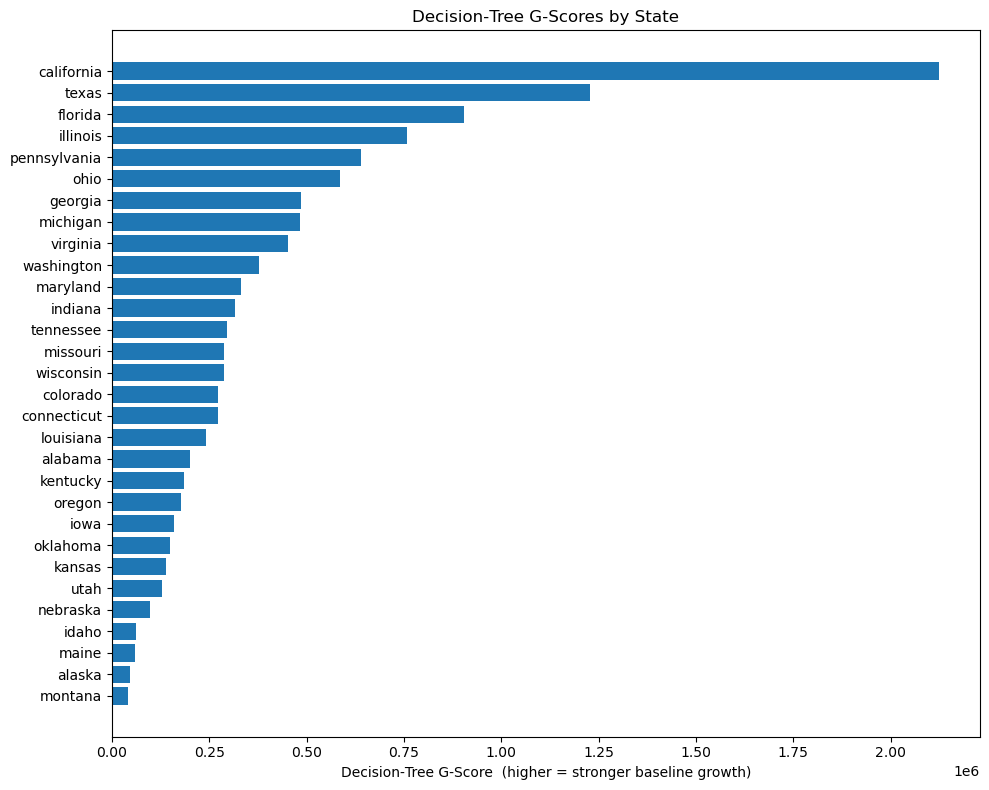

In [59]:
print("Top 10 states (Decision‑Tree G‑score):")
print(tree_state_score.head(10), "\n")

print("Bottom 10 states:")
print(tree_state_score.tail(10))

# ------------------------------------------------------------------
# 2)  Horizontal bar chart of ALL states
# ------------------------------------------------------------------
plt.figure(figsize=(10, 8))
plt.barh(tree_state_score["State"], tree_state_score["G_score_tree"])
plt.gca().invert_yaxis()
plt.xlabel("Decision‑Tree G‑Score  (higher = stronger baseline growth)")
plt.title("Decision‑Tree G‑Scores by State")
plt.tight_layout()
plt.show()

In [60]:
from sklearn.model_selection import cross_val_score

# 1) Adjusted R²
n = len(y)
p = len(vars_X)
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {r2_adj:.4f}")

# 2) AIC & BIC (assume k = number of leaves as model complexity)
rss = np.sum((y - y_hat) ** 2)
k   = best_tree.get_n_leaves()
aic = n * np.log(rss / n) + 2 * k
bic = n * np.log(rss / n) + np.log(n) * k
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

# 3) 5‑fold CV R²
cv_r2 = cross_val_score(best_tree, X, y, cv=cv, scoring="r2")
print(f"5‑fold CV R²: {cv_r2.mean():.4f} (± {cv_r2.std():.4f})")


Adjusted R²: 0.9998
AIC: 7569.66
BIC: 8280.74
5‑fold CV R²: 0.9638 (± 0.0403)


In [76]:
tree_state_score.to_csv('decision_tree_scores.csv',index=False)

## RF Proximity

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [70]:
vars_X = ["asset_quality", "profitability", "low"]

# merged_panel built earlier: YearQuarter‑by‑State observations
panel = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_raw = panel[vars_X].values
y      = panel["GDP_pre"].values
states = panel["State"].values

# RFs don’t need scaling, but keep same workflow
scaler = RobustScaler()
X = scaler.fit_transform(X_raw)

In [77]:
# 2)   Fit Random Forest
# ---------------------------------------------------------------
rf = RandomForestRegressor(
        n_estimators = 92,
        max_depth    = None,
        min_samples_leaf = 1,
        oob_score    = True,
        random_state = 42,
        n_jobs       = -1
     )

rf.fit(X, y)
print(f"OOB‑R² : {rf.oob_score_: .4f}")

OOB‑R² :  0.9498


In [78]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
import numpy as np

# 1) In‑sample predictions
y_hat = rf.predict(X)

# 2) Sample size and number of predictors
n = len(y)
p = X.shape[1]

# --- Adjusted R² ---
r2 = r2_score(y, y_hat)
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R²: {r2_adj:.4f}")

# --- AIC & BIC (use total leaves across all trees as 'k') ---
rss = np.sum((y - y_hat) ** 2)
k   = sum(est.tree_.n_leaves for est in rf.estimators_)
aic = n * np.log(rss / n) + 2 * k
bic = n * np.log(rss / n) + np.log(n) * k
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

# --- 5‑fold CV R² ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(rf, X, y, cv=cv, scoring="r2")
print(f"5‑fold CV R²: {cv_r2.mean():.4f} (± {cv_r2.std():.4f})")


Adjusted R²: 0.9928
AIC: 36257.63
BIC: 91734.37
5‑fold CV R²: 0.8910 (± 0.0245)


In [79]:
# 3)   Proximity matrix  P_{ij}
#      P_{ij} = (1/T) Σ_t  1{ leaf_t(i) == leaf_t(j) }
# ---------------------------------------------------------------
# Leaf indices for every tree  →  shape (n_samples, n_trees)
leaf_index = rf.apply(X)          # dtype = int32

n_samples, n_trees = leaf_index.shape
P = np.zeros((n_samples, n_samples), dtype=np.float32)

#   For each tree, add 1 where observations share the same leaf.
for t in range(n_trees):
    leaves = leaf_index[:, t]
    # group by leaf id
    _, inv = np.unique(leaves, return_inverse=True)
    # build an indicator matrix via broadcasting
    # P += 1 where leaf ids match
    P += (inv[:, None] == inv[None, :])


P /= n_trees       # convert counts → share of trees   (0‒1)

In [80]:
# 4)   Observation‑level proximity score
obs_score = (P.sum(axis=1) - 1) / (n_samples - 1)   # exclude diagonal

panel["G_score_rfprox"] = obs_score

# ---------------------------------------------------------------
# 5)   Aggregate to STATE‑level score
# ---------------------------------------------------------------
rf_state_score = (
    panel.groupby("State")["G_score_rfprox"]
         .mean()                       # mean over quarters
         .reset_index()
         .sort_values("G_score_rfprox", ascending=False)
         .rename(columns={"G_score_rfprox": "G_score"})
         .reset_index(drop=True)
)

print("\nRandom‑Forest Proximity G‑scores (top 10):")
print(rf_state_score.head(10))


Random‑Forest Proximity G‑scores (top 10):
        State   G_score
0  washington  0.007271
1    maryland  0.007230
2    colorado  0.007171
3  california  0.007160
4     georgia  0.006963
5    virginia  0.006758
6     montana  0.006704
7     florida  0.006567
8       idaho  0.006534
9        utah  0.006458


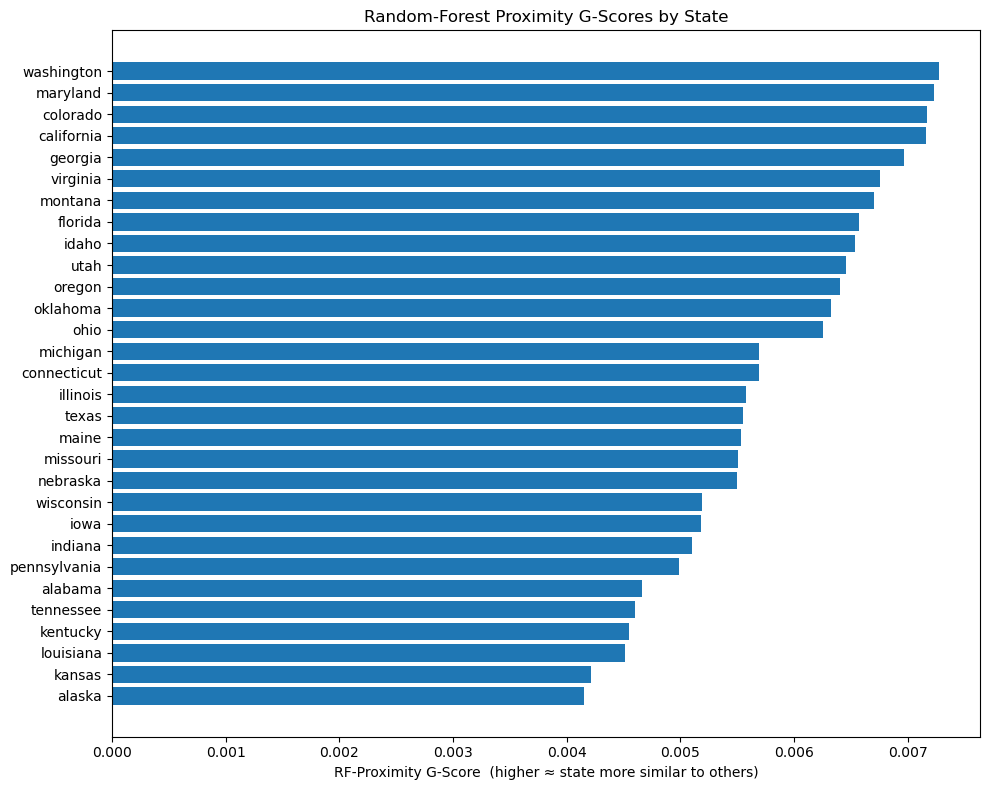

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.barh(rf_state_score["State"], rf_state_score["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("RF‑Proximity G‑Score  (higher ≈ state more similar to others)")
plt.title("Random‑Forest Proximity G‑Scores by State")
plt.tight_layout()
plt.show()

In [82]:
rf_state_score.to_csv('rf_proximity_scores.csv',index=False)

## XG Boost

In [83]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [84]:
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)


In [91]:
from sklearn.pipeline import Pipeline

In [85]:
vars_X = ["asset_quality", "profitability", "low"]   # predictors
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X = panel[vars_X].values
y = panel["GDP_pre"].values
states = panel["State"].values


In [92]:
pipe = Pipeline([
    ("scaler", RobustScaler()),        # optional for XGB, required for other models
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

param_grid = {
    "n_estimators":   [100, 400],
    "learning_rate":  [0.01, 0.1],
    "max_depth":      [3, 4, 5],
    "subsample":      [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5]
}

xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
     )

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
        xgb, param_grid,
        cv=cv,
        scoring="neg_mean_squared_error",
        verbose=0
     ).fit(X, y)

best_xgb = grid.best_estimator_
print("Best XGBoost params:", grid.best_params_)

Best XGBoost params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 400, 'subsample': 0.8}


In [93]:
y_hat = best_xgb.predict(X)
ins_r2  = r2_score(y, y_hat)
ins_rmse = np.sqrt(mean_squared_error(y, y_hat))

cv_r2 = cross_val_score(best_xgb, X, y, cv=cv, scoring="r2")
print(f"In‑sample  R²  : {ins_r2: .4f}  |  RMSE : {ins_rmse: .5f}")
print(f"5‑fold CV R²  : {cv_r2.mean(): .4f}  (±{cv_r2.std(): .4f})")

In‑sample  R²  :  0.9995  |  RMSE :  9729.79288
5‑fold CV R²  :  0.9411  (± 0.0388)


In [97]:
panel["G_score_xgb"] = y_hat

# ---------------------------------------------------------------
# 5)  Aggregate to state‑level score
# ---------------------------------------------------------------
xgb_state_score = (
    panel.groupby("State")["G_score_xgb"]
         .mean()                       # mean across quarters
         .reset_index()
         .sort_values("G_score_xgb", ascending=False)
         .rename(columns={"G_score_xgb": "G_score"})
         .reset_index(drop=True)
)

print("\nXGBoost G‑scores  (top 10 states)")
print(xgb_state_score.head(10))


XGBoost G‑scores  (top 10 states)
          State       G_score
0    california  2.119756e+06
1         texas  1.225263e+06
2       florida  9.051139e+05
3      illinois  7.556928e+05
4  pennsylvania  6.385082e+05
5          ohio  5.848514e+05
6       georgia  4.869244e+05
7      michigan  4.838872e+05
8      virginia  4.521372e+05
9    washington  3.780395e+05


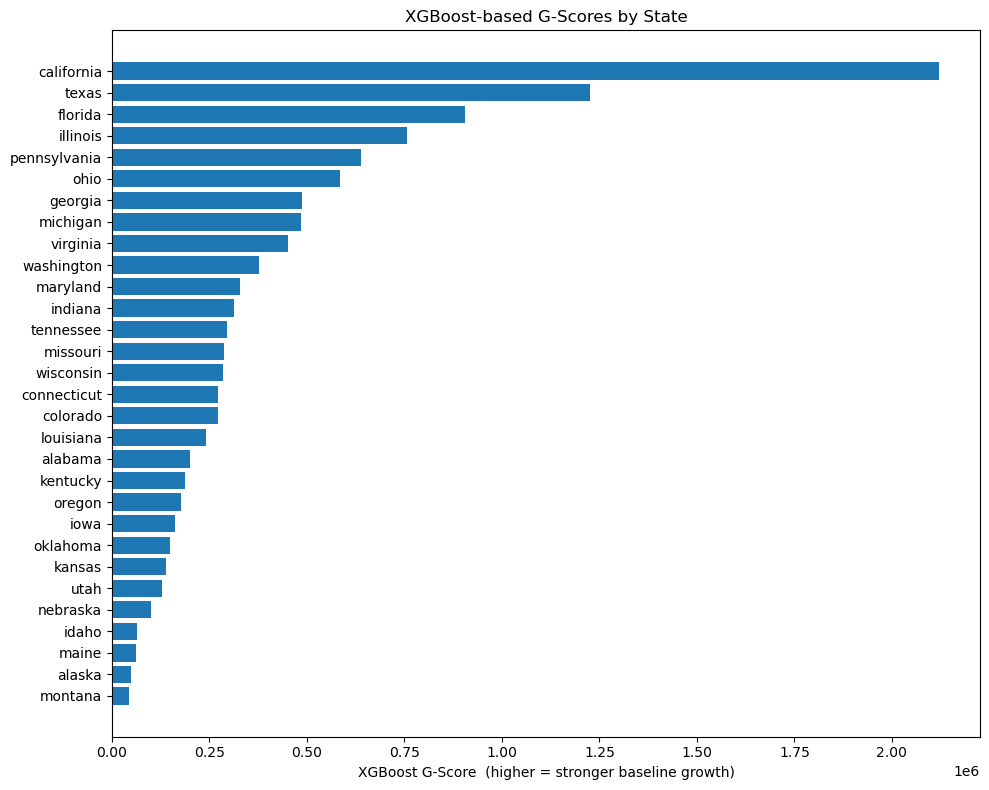

In [98]:
plt.figure(figsize=(10,8))
plt.barh(xgb_state_score["State"], xgb_state_score["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("XGBoost G‑Score  (higher = stronger baseline growth)")
plt.title("XGBoost‑based G‑Scores by State")
plt.tight_layout()
plt.show()

In [99]:
xgb_state_score.to_csv('xgboost_scores.csv',index = False)

## Gaussian Process Regression

In [100]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ConstantKernel as C

In [101]:
# ---------------------------------------------------------------
vars_X = ["asset_quality", "profitability", "low"]
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_raw = panel[vars_X].values
y      = panel["GDP_pre"].values
states = panel["State"].values

# Standardise predictors (GPR sensitive to scale)
scaler = RobustScaler()
X = scaler.fit_transform(X_raw)

# ---------------------------------------------------------------
# 2)  Kernel & GP model
# ---------------------------------------------------------------
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=np.ones(X.shape[1]),
                                      length_scale_bounds=(1e-2, 1e2),
                                      nu=1.5) \
         + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-8,1e-1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20,random_state=42)
gpr.fit(X, y)

'''gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=10,
                               random_state=42)

gpr.fit(X, y)'''

print("\nLearned kernel:", gpr.kernel_)


Learned kernel: 31.6**2 * Matern(length_scale=[0.0582, 0.206, 0.554], nu=1.5) + WhiteKernel(noise_level=0.1)


d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [102]:
y_hat   = gpr.predict(X)
ins_r2  = r2_score(y, y_hat)
ins_rmse = np.sqrt(mean_squared_error(y, y_hat))

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(gpr, X, y, cv=cv, scoring="r2")

print("\n=== GPR goodness‑of‑fit ===")
print(f"In‑sample  R²  : {ins_r2: .4f}  |  RMSE : {ins_rmse: .5f}")
print(f"5‑fold CV R²   : {cv_r2.mean(): .4f}  (±{cv_r2.std(): .4f})")

# ---------------------------------------------------------------
# 4)  Observation‑level G‑score   (posterior mean)
# ---------------------------------------------------------------
panel["G_score_gpr"] = y_hat

d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found f


=== GPR goodness‑of‑fit ===
In‑sample  R²  :  0.9998  |  RMSE :  5390.82852
5‑fold CV R²   :  0.8786  (± 0.1934)


d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
d:\Anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.1. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



GPR  G‑scores  (top 10 states)
          State       G_score
0    california  2.123596e+06
1         texas  1.228187e+06
2       florida  9.052748e+05
3      illinois  7.580981e+05
4  pennsylvania  6.389404e+05
5          ohio  5.851015e+05
6       georgia  4.868295e+05
7      michigan  4.837685e+05
8      virginia  4.519880e+05
9    washington  3.787206e+05


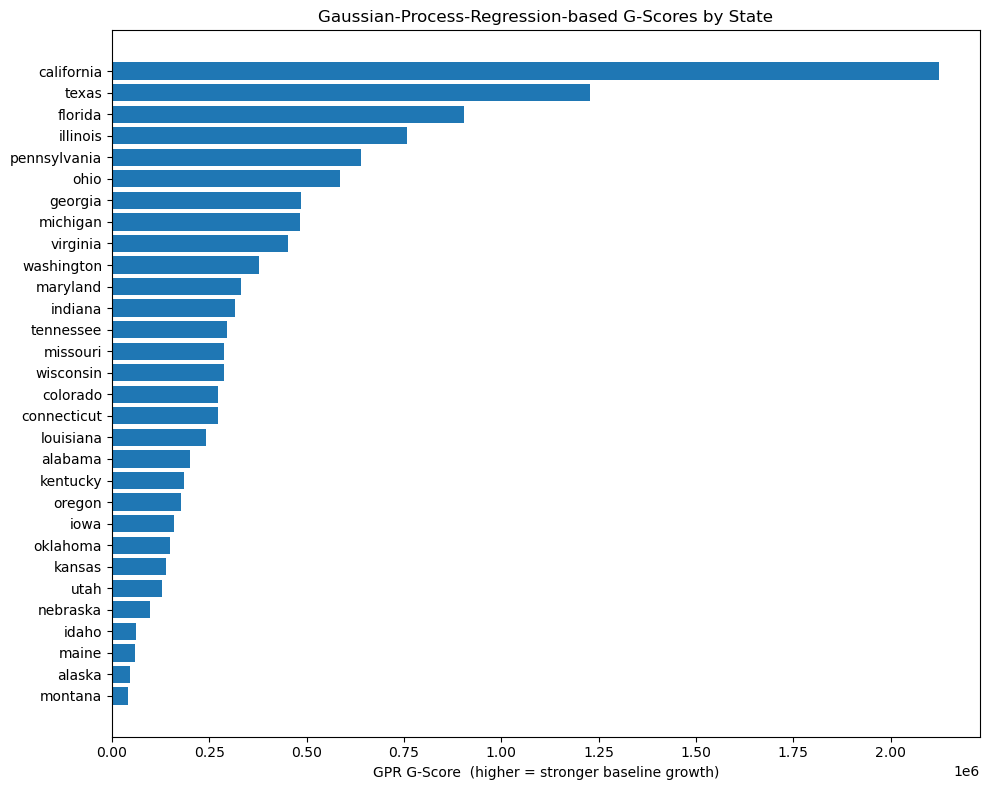

In [103]:
gpr_state_score = (
    panel.groupby("State")["G_score_gpr"]
         .mean()
         .reset_index()
         .sort_values("G_score_gpr", ascending=False)
         .rename(columns={"G_score_gpr": "G_score"})
         .reset_index(drop=True)
)

print("\nGPR  G‑scores  (top 10 states)")
print(gpr_state_score.head(10))

# ---------------------------------------------------------------
# 6)  Visualise
# ---------------------------------------------------------------
plt.figure(figsize=(10, 8))
plt.barh(gpr_state_score["State"], gpr_state_score["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("GPR G‑Score  (higher = stronger baseline growth)")
plt.title("Gaussian‑Process‑Regression‑based G‑Scores by State")
plt.tight_layout()
plt.show()

In [104]:
gpr_state_score.to_csv('gpr_state_scores.csv',index = False)

## Penalised Low Dimensional Projection

In [105]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [106]:
vars_X = ["asset_quality", "profitability", "low"]
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_raw = panel[vars_X].to_numpy(float)
y      = panel["GDP_pre"].to_numpy(float)
states = panel["State"].values

# Standardise predictors (always before PCA)
Xs = RobustScaler().fit_transform(X_raw)

In [107]:
pca = PCA(n_components=0.95, svd_solver="full")   # here K≤3 anyway
Z   = pca.fit_transform(Xs)                       # low‑dim repr.

print("Explained variance by retained PCs:", pca.explained_variance_ratio_)

Explained variance by retained PCs: [0.68804472 0.2327187  0.07923657]


In [108]:
alphas = np.logspace(-4, 3, 50)
ridge  = RidgeCV(alphas=alphas, cv=5).fit(Z, y)
print("Chosen ridge α:", ridge.alpha_)

#             β in PC‑space  →  β in original‑X space
beta_pc   = ridge.coef_                   # shape (K,)
beta_orig = pca.components_.T @ beta_pc   # shape (p,)


Chosen ridge α: 1000.0


In [109]:
y_hat   = ridge.predict(Z)
r2_in   = r2_score(y, y_hat)
rmse_in = np.sqrt(mean_squared_error(y, y_hat))
cv_r2   = cross_val_score(ridge, Z, y, cv=KFold(5, shuffle=True, random_state=42),
                          scoring="r2")

print(f"In‑sample R² : {r2_in: .4f} | RMSE : {rmse_in: .5f}")
print(f"5‑fold CV R² : {cv_r2.mean(): .4f}  (±{cv_r2.std(): .4f})")

In‑sample R² :  0.0422 | RMSE :  408975.87306
5‑fold CV R² :  0.0097  (± 0.0354)


In [110]:
G_scores = Xs @ beta_orig                # uses original X scale

panel["G_score_pldp"] = G_scores

# Aggregate to state
pldp_state = (
    panel.groupby("State")["G_score_pldp"]
         .mean()
         .reset_index()
         .sort_values("G_score_pldp", ascending=False)
         .rename(columns={"G_score_pldp": "G_score"})
         .reset_index(drop=True)
)

print("\nPLDP G‑scores  (top 10 states):")
print(pldp_state.head(10))


PLDP G‑scores  (top 10 states):
          State       G_score
0       georgia  64413.330810
1          utah  62233.523155
2       florida  60245.303365
3    california  60077.595921
4      michigan  51676.645615
5      virginia  51107.400874
6       alabama  42050.179976
7      colorado  39368.945175
8      illinois  34669.060042
9  pennsylvania  22805.850113


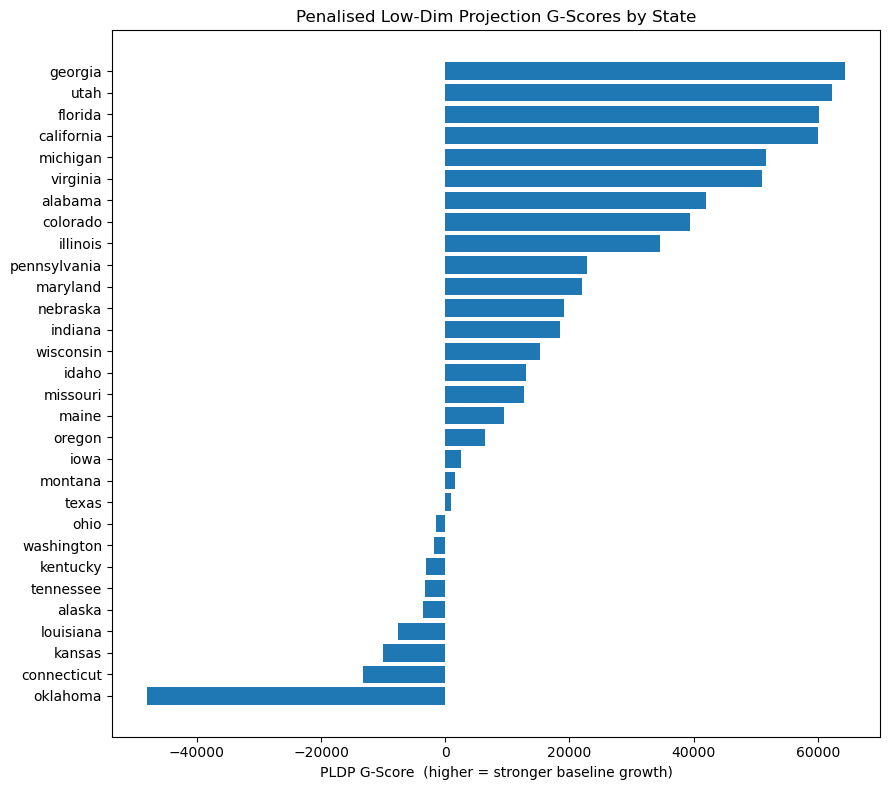

In [111]:
plt.figure(figsize=(9,8))
plt.barh(pldp_state["State"], pldp_state["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("PLDP G‑Score  (higher = stronger baseline growth)")
plt.title("Penalised Low‑Dim Projection G‑Scores by State")
plt.tight_layout()
plt.show()

In [112]:
vars_X = ["asset_quality", "profitability", "low"]
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_raw = panel[vars_X].to_numpy(float)
y      = panel["GDP_pre"].to_numpy(float)
states = panel["State"].values

# Standardise predictors (always before PCA)
Xs = StandardScaler().fit_transform(X_raw)

In [113]:
pca = PCA(n_components=0.95, svd_solver="full")   # here K≤3 anyway
Z   = pca.fit_transform(Xs)                       # low‑dim repr.

print("Explained variance by retained PCs:", pca.explained_variance_ratio_)

Explained variance by retained PCs: [0.4403816  0.32061419 0.23900421]


In [114]:
alphas = np.logspace(-4, 3, 50)
ridge  = RidgeCV(alphas=alphas, cv=5).fit(Z, y)
print("Chosen ridge α:", ridge.alpha_)

#             β in PC‑space  →  β in original‑X space
beta_pc   = ridge.coef_                   # shape (K,)
beta_orig = pca.components_.T @ beta_pc   # shape (p,)


Chosen ridge α: 1000.0


In [115]:
y_hat   = ridge.predict(Z)
r2_in   = r2_score(y, y_hat)
rmse_in = np.sqrt(mean_squared_error(y, y_hat))
cv_r2   = cross_val_score(ridge, Z, y, cv=KFold(5, shuffle=True, random_state=42),
                          scoring="r2")

print(f"In‑sample R² : {r2_in: .4f} | RMSE : {rmse_in: .5f}")
print(f"5‑fold CV R² : {cv_r2.mean(): .4f}  (±{cv_r2.std(): .4f})")

In‑sample R² :  0.0419 | RMSE :  409035.96451
5‑fold CV R² :  0.0087  (± 0.0418)


In [116]:
G_scores = Xs @ beta_orig                # uses original X scale

panel["G_score_pldp"] = G_scores

# Aggregate to state
pldp_state = (
    panel.groupby("State")["G_score_pldp"]
         .mean()
         .reset_index()
         .sort_values("G_score_pldp", ascending=False)
         .rename(columns={"G_score_pldp": "G_score"})
         .reset_index(drop=True)
)

print("\nPLDP G‑scores  (top 10 states):")
print(pldp_state.head(10))


PLDP G‑scores  (top 10 states):
        State       G_score
0  california  49358.869265
1     florida  48597.621654
2     georgia  47911.970891
3    colorado  39120.474515
4    virginia  36616.524414
5    michigan  29051.721659
6    maryland  24441.075693
7        utah  16876.700859
8     alabama  14030.089498
9       idaho  10787.666130


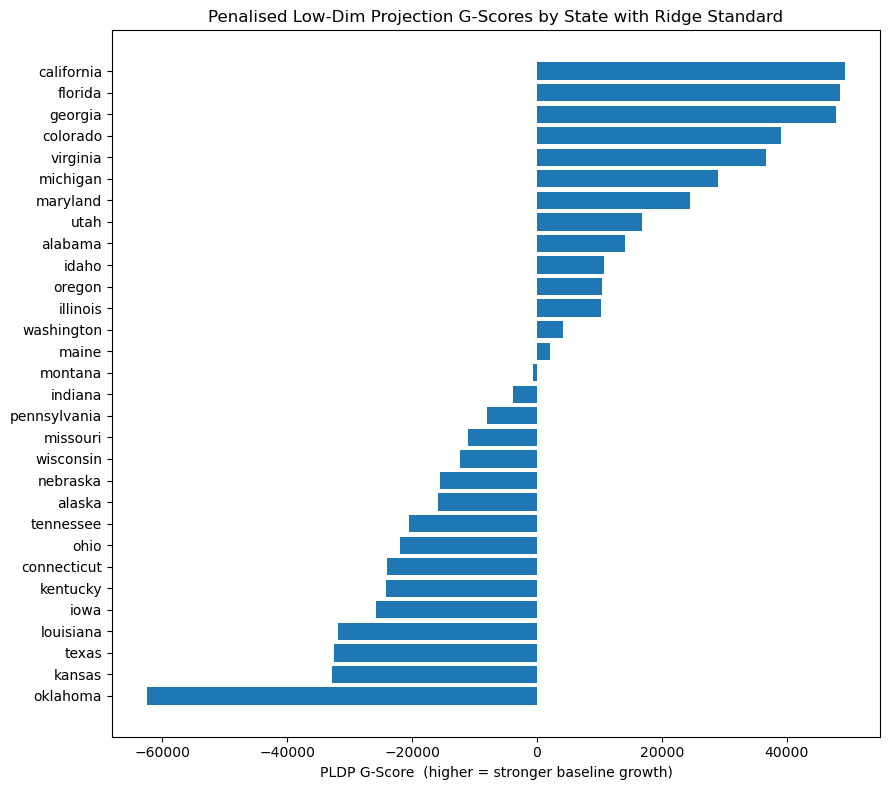

In [117]:
plt.figure(figsize=(9,8))
plt.barh(pldp_state["State"], pldp_state["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("PLDP G‑Score  (higher = stronger baseline growth)")
plt.title("Penalised Low‑Dim Projection G‑Scores by State with Ridge Standard")
plt.tight_layout()
plt.show()

### Using ElasticNet

In [118]:
from sklearn.decomposition import PCA
from sklearn.preprocessing  import StandardScaler
from sklearn.linear_model   import ElasticNetCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np, pandas as pd, matplotlib.pyplot as plt

In [119]:
# ---------------- 1) DATA  ----------------
vars_X = ["asset_quality", "profitability", "low"]
panel  = merged_panel.dropna(subset=vars_X + ["GDP_pre"]).copy()

X_std = StandardScaler().fit_transform(panel[vars_X].to_numpy(float))
y     = panel["GDP_pre"].to_numpy(float)
states = panel["State"].values

# ---------------- 2) PCA  -----------------
pca = PCA(n_components=0.95, svd_solver="full")
Z   = pca.fit_transform(X_std)          # low‑dim features

# ---------------- 3) ELASTIC‑NET CV  ------
enet = ElasticNetCV(
        l1_ratio = np.linspace(0.05, 0.95, 10),   # 10 points between almost‑ridge and almost‑lasso
        alphas   = np.logspace(-4, 2, 50),        # penalty strengths
        cv       = 5,
        max_iter = 10_000,
        random_state = 42)
enet.fit(Z, y)

print(f"Chosen l1_ratio = {enet.l1_ratio_:.2f}  |  alpha = {enet.alpha_:.4g}")

Chosen l1_ratio = 0.05  |  alpha = 100


In [120]:
# back‑transform to original variables
beta_pc   = enet.coef_                  # γ in PC space
beta_orig = pca.components_.T @ beta_pc # β in original‑X space

# ---------------- 4) METRICS  -------------
y_hat   = enet.predict(Z)
r2_in   = r2_score(y, y_hat)
rmse_in = np.sqrt(mean_squared_error(y, y_hat))

cv = KFold(5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(enet, Z, y, cv=cv, scoring="r2")

print(f"In‑sample R² : {r2_in: .4f} | RMSE : {rmse_in: .5f}")
print(f"5‑fold CV R² : {cv_r2.mean(): .4f} (±{cv_r2.std(): .4f})")


In‑sample R² :  0.0019 | RMSE :  417494.36760
5‑fold CV R² : -0.0243 (± 0.0447)


In [121]:
# ---------------- 5) G‑SCORES -------------
G_scores = X_std @ beta_orig
panel["G_score_enet"] = G_scores

enet_state = (
    panel.groupby("State")["G_score_enet"]
         .mean().reset_index()
         .sort_values("G_score_enet", ascending=False)
         .rename(columns={"G_score_enet": "G_score"})
         .reset_index(drop=True)
)

print("\nElastic‑Net G‑scores  (top 10 states)")
print(enet_state.head(10))


Elastic‑Net G‑scores  (top 10 states)
        State      G_score
0  california  1846.781671
1     florida  1809.314280
2     georgia  1762.855861
3    colorado  1407.401199
4    virginia  1398.078580
5    michigan  1076.105203
6        utah   903.587312
7    maryland   870.857821
8     alabama   517.622322
9    illinois   383.184046


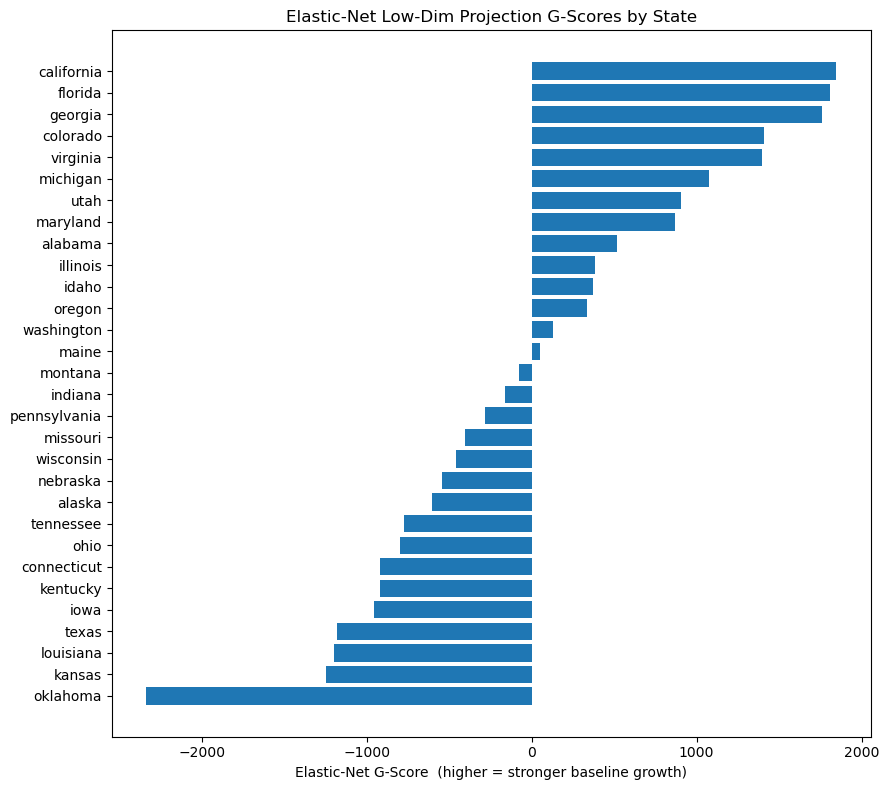

In [122]:
# ---------------- 6) PLOT -----------------
plt.figure(figsize=(9,8))
plt.barh(enet_state["State"], enet_state["G_score"])
plt.gca().invert_yaxis()
plt.xlabel("Elastic‑Net G‑Score  (higher = stronger baseline growth)")
plt.title("Elastic‑Net Low‑Dim Projection G‑Scores by State")
plt.tight_layout(); plt.show()